<a href="https://colab.research.google.com/github/MatheusOrange211/Serie-temporal-covid-19/blob/main/Serie_Temporal_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import zipfile
import requests
from io import BytesIO
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

#Funções

Os dados estão originalmente salvos no github em extensão `.zip `. Isso porque o arquivo possui mais de 50MB de tamanho. Pensando em facilitar a vida de quem for analisar este projeto, e com a ajuda do [stackOverflow](https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url) (obviamente), criei uma função que realiza uma requisição da URL onde está o meu arquivo, dando um `get`(pegando) os meus dados de lá. Depois com zipfile, eu tento extrair o arquivo, no entanto, por estar pegando de uma for diferente do convencional, meus dados estão comportados de uma forma diferente. Usando  `BytesIo`, eu evito o seguinte erro de entendimento:

```
'bytes' object has no attribute 'seek'
```
Por fim, extraio o arquivo e o retorno. Entretanto, o mesmo não apareça de primeira no seu colab, a não ser que você atualize. Clique no botão com a pastinha e um simbolo de reload. o arquivo agora está lá. Pronto para uso.

In [2]:
def unzip_url_file(url):
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(BytesIO(r.content))
  file = z.extractall()
  return file

Formatando os dados do dataframe Brasil e retornando ele ordenado por data ( do mais antigo até o mais atual ).

In [3]:
def formated_df_brasil(dataset: pd.DataFrame):
  dataset = dataset.drop(columns=["estado","municipio","coduf"],axis=1) #estamos falando do ambito nacional \(°_°)/
  dataset["data"] = pd.to_datetime(dataset['data'],format="%d/%m/%Y")
  dataset["regiao"] = dataset["regiao"].astype(str)
  dataset["populacaoTCU2019"] = dataset["populacaoTCU2019"].astype(int)
  dataset = dataset.sort_values(by="data")
  dataset.reset_index(drop=True,inplace=True)
  return dataset

plotar lineplots simples

In [4]:
def plot_br(data,yaxis, title:str = ""):
  plt.figure(figsize=(15,5))
  ax = sns.lineplot(data=data,x=data.index,y=yaxis)
  plt.title(title)
  return ax;

plotar dois gráficos juntos de forma simples

In [5]:
def plot_graficos_simples(data1, yaxis1,yaxis2,title:str="",lista_legend:list = []):
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data1,x=data1.index,y=yaxis1)
  sns.lineplot(data=data1,x=data1.index,y=yaxis2)
  plt.title(title)
  plt.legend(lista_legend)
  return plt.show()

plotar gráficos de casos/ óbitos, média móvel e tendência

In [93]:
def plot_media_trend(data1,data2,yaxis1,yaxis2,yaxis3,title:str="",lista_legend:list = []):
  
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data1,x=data1.index,y=yaxis1)
  sns.lineplot(data=data1,x=data1.index,y=yaxis2)
  sns.lineplot(data=data2,x=data2.index,y=yaxis3)

  plt.title(title)
  plt.legend(lista_legend)
  return plt.show()

#Importando Dados

In [7]:
url = "https://github.com/MatheusOrange211/Serie-temporal-covid-19/raw/main/dados/dados_covid_mod_1.zip"


In [8]:
 unzip_url_file(url) #arquivo descompactado e já disponível para uso.
 file_covid = "/content/dados_covid_mod_1.csv"

In [9]:
dados = pd.read_csv(file_covid,sep=";",engine='python')
dados

,regiao,estado,municipio,coduf,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,NaN,NaN,76,25/02/2020,9,210147125.0,0,0,0,0
1,Brasil,NaN,NaN,76,26/02/2020,9,210147125.0,1,1,0,0
2,Brasil,NaN,NaN,76,27/02/2020,9,210147125.0,1,0,0,0
3,Brasil,NaN,NaN,76,28/02/2020,9,210147125.0,1,0,0,0
4,Brasil,NaN,NaN,76,29/02/2020,9,210147125.0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1048570,Sudeste,SP,Holambra,35,24/09/2020,39,14930.0,346,9,3,0
1048571,Sudeste,SP,Holambra,35,25/09/2020,39,14930.0,347,1,3,0
1048572,Sudeste,SP,Holambra,35,26/09/2020,39,14930.0,352,5,3,0
1048573,Sudeste,SP,Holambra,35,27/09/2020,40,14930.0,352,0,3,0


In [10]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   regiao            1048575 non-null  object 
 1   estado            1048245 non-null  object 
 2   municipio         1034637 non-null  object 
 3   coduf             1048575 non-null  int64  
 4   data              1048575 non-null  object 
 5   semanaEpi         1048575 non-null  int64  
 6   populacaoTCU2019  1043823 non-null  float64
 7   casosAcumulado    1048575 non-null  int64  
 8   casosNovos        1048575 non-null  int64  
 9   obitosAcumulado   1048575 non-null  int64  
 10  obitosNovos       1048575 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 88.0+ MB


Os dados vem diretamente do site do governo federal e vão até a data de 17/01/2021. Pra começar, temos os dados nacionais e dados por estados/Regiões. vou dividir o dataset em dois, analisando de forma mais ampla, vendo todo o País, e olhando depois, por regiões.

In [11]:
dados_brasil = dados.query("regiao == 'Brasil'")
dados_brasil = formated_df_brasil(dados_brasil)
dados_brasil.head()

,regiao,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,2020-02-25,9,210147125,0,0,0,0
1,Brasil,2020-02-26,9,210147125,1,1,0,0
2,Brasil,2020-02-27,9,210147125,1,0,0,0
3,Brasil,2020-02-28,9,210147125,1,0,0,0
4,Brasil,2020-02-29,9,210147125,2,1,0,0


Criar um dataframe de Série Temporal Para analisar casos novos e óbitos Novos.

In [12]:
br_casos_obitos = dados_brasil[["data","casosNovos","obitosNovos"]].copy()
br_casos_obitos["mes"] = br_casos_obitos["data"].dt.month
br_casos_obitos["ano"] = br_casos_obitos["data"].dt.year
br_casos_obitos.set_index('data',inplace=True)

In [13]:
br_casos_obitos.head(5)

,casosNovos,obitosNovos,mes,ano
data,,,,
2020-02-25,0,0,2,2020
2020-02-26,1,0,2,2020
2020-02-27,0,0,2,2020
2020-02-28,0,0,2,2020
2020-02-29,1,0,2,2020


#Prevendo Casos Novos - Brasil

temos orignalmente isso

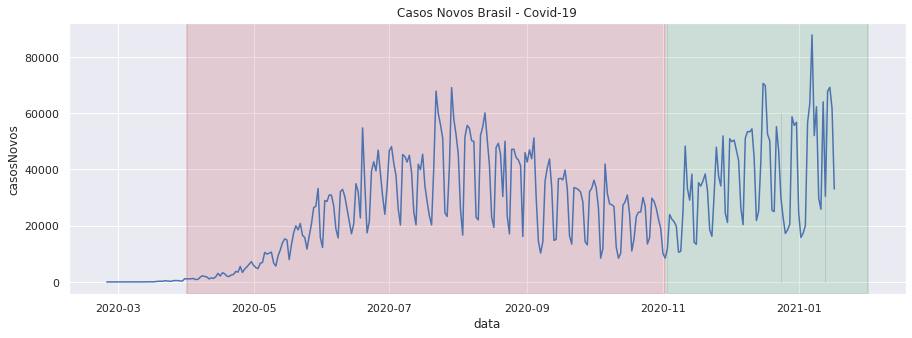

In [14]:
plot_br(br_casos_obitos,"casosNovos",'Casos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-04-01'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)

Observando os casos novos ao longo dos meses de 2020, temos várias curvas ao longo do ano, começando em 2020-05 (Maio) uma crescente de casos, chegando ao ápice de mais de 60 mil casos entre Julho e Agosto, tendo uma queda, em uma primeira onda, e depois, a partir de novembro, o crescimento da segunda onda com muito mais força, ultrapassando os mais de 80 novos casos diários no início de janeiro de 2021. 
**Observação**: Em vermelho, temos a primeira onda e em verde a segunda onda se configurando.

Algumas informações interessantes a se analisar, como a média móvel, contudo, assim como vemos em jornais, a média móvel dos últimos 7 dias.

In [ ]:
br_casos_obitos["media_movel_7_dias"] = br_casos_obitos["casosNovos"].rolling(window=7,center=True).mean()

No fim, o que temos é isso:

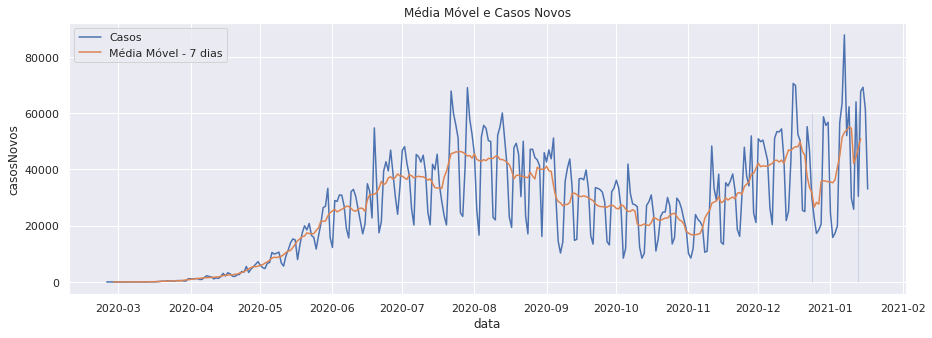

In [16]:
plot_graficos_simples(br_casos_obitos,"casosNovos","media_movel_7_dias",
                      "Média Móvel e Casos Novos",["Casos","Média Móvel - 7 dias"])

Olhando então a configuração das médias móveis, então vamos começar a realizar previsões de buscar prever novos casos.

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_br = seasonal_decompose(br_casos_obitos["casosNovos"],freq=12)

Temos abaixo, a demonstração das tendências de casos novos ao longo do ano de 2020 junto da média móvel e dos casos.

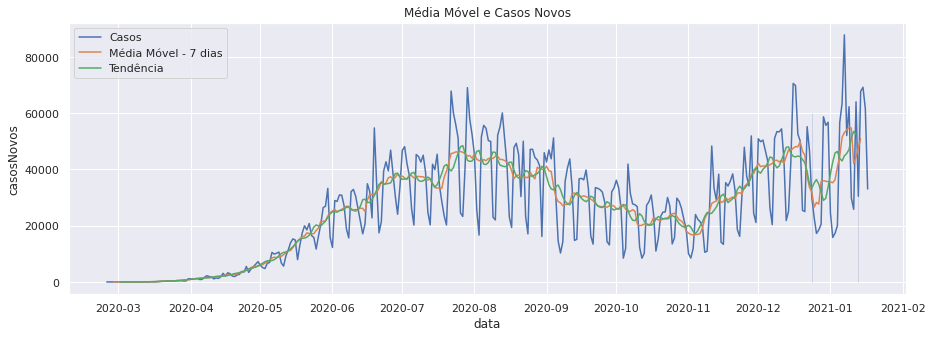

In [94]:
tendencia_casos_novos = decomposicao_br.trend

plot_media_trend(br_casos_obitos,tendencia_casos_novos,"casosNovos","media_movel_7_dias",
                      tendencia_casos_novos,"Média Móvel e Casos Novos",
                      ["Casos","Média Móvel - 7 dias","Tendência"])

Preparando então nosso dataset para prever novos casos em 2021. A ideia é tentar prever os casos em 2021 para os 3 primeiros meses. Contudo, temos que ter em mente algumas coisas:

* A vacina da Covid-19 está em fase inicial de implementação;
* Os dados da covid são muito recentes, não sendo possível prever por longos períodos, além é claro, do cenário poder mudar dado que tudo isso ainda é novo em nossa sociedade;

Vamos tentar prever o mês de Dezembro e se funcionar, tentaremos prever janeiro a março, se possível. Contudo, temos um grande problema para resolver antes de mais nada, **Qual modelo de forecast (previsão) utilizar? e por quê?**

#**Previsões Casos**

## <font size='12px'> **Observações Iniciais**</font>

Uma das primeiras coisas que se percebe quando trabalhamos com séries temporais é a quantidade de modelos de previsão e suas respectivas capacidades em prever um determinado conjunto de dados, com base em algumas específicadades.<br>
Quando você começa a trabalhar com coisas assim, requer um tempo de leitura para poder identificar características que possam te auxiliar a compreender o "melhor" modelo para prever seus dados. Vamos ver então o que já temos sabemos no momento:

* DataFrame composto por datas (indice) e colunas de casos e óbitos;
* Os dados de **casos e óbitos** são do tipo **QUANTITATIVO - DISCRETO**;

<font size='8px'>**Algumas questões a se analisar**</font><br>
A covid-19 possui em torno de um ano de existência (em relação a pandemia). Como trabalhar com a questão da *sazonalidade*? Afinal, por sazonlidade, entendemos ser uma repetição que ocorre sempre em determinados períodos de tempo, como explicado no site da [Portal Action](http://www.portalaction.com.br/series-temporais/23-sazonalidade#:~:text=Dizemos%20que%20uma%20s%C3%A9rie%20temporal,m%C3%AAs%20em%20todos%20os%20anos.):
>"Dizemos que uma série temporal é sazonal quando os fenômenos que ocorrem durante o tempo se repete a cada período idêntico de tempo, ou seja, fenômenos que ocorrem diariamente em uma certa hora, todos os dias, ou em um certo mês em todos os anos. Um exemplo fácil de visualizar seria o aumento das vendas de passagens aéreas todos os finais de ano, ou ainda, o aumento das vendas do comércio no período do natal."

Entretanto, a covid-19 ainda é uma doença desconhecida. Muitas informações relacionadas a ela ainda serão confirmadas com o passar do tempo, mas apenas nos resta paciência para aguardar um melhor entendimento quanto a sua sazonalidade.Como aponta a matéria publicada no [UOL](https://www.uol.com.br/vivabem/noticias/bbc/2020/09/15/covid-19-do-futuro-devera-ser-sazonal-como-outros-virus-respiratorios-sugerem-pesquisadores.htm), o coronavírus tem chances de se torna uma doença sazonal assim como a gripe e outras doenças respiratórias que aparecem mais no inverno como aponta em um trecho da matéria:

>Já conhecemos diversos vírus que causam mais problemas em determinadas estações do ano, como o da influenza e o vírus sincicial respiratório (RSV) no inverno ou o da parainfluenza em setembro para o Hemisfério Sul.

Contudo, até lá, é necessário paciência pois é preciso ter uma imunidade coletiva suficiente para que este efeito seja gerado.

>"A covid-19 veio para ficar e ela continuará a causar surtos ao longo do tempo até que a imunidade coletiva seja atingida. Assim, o público precisará aprender a viver com a doença e a continuar praticando as melhores medidas de prevenção, incluindo usar máscaras, evitar aglomerações, distanciamento físico e higiene das mãos", explicou em comunicado à imprensa Hassan Zaraket, líder do estudo e pesquisador da Universidade Americana em Beirute, no Líbano."

Outro ponto importante para termos em mente é : **Qual Modelo utilizar no projeto para realizar previsões?**


Temos muitos modelos de predição disponíveis. Todos são ótimos, mas nem todos atendem a nossa demanda, que é prever casos de uma doença. Doenças tem aspectos particulares a se levar em conta, como a *bendita* sazonalidade. Há modelos em que ela tem que ser levada em conta, outros não.Ao longo do projeto, irei explicando mais sobre com ir trabalhando com a sazonalidade no casos do coronavírus e sobre o modelo usado. Mas tenha em mente que, independente do modelo ou do quão preciso ele possa parecer, no fim, o comportamento humano é que vai decidir se os números de casos sobem ou descem, se continuamos nesta indeterminada onda de **ondas de casos** ou se conseguimos ir diminuindo. Isso, creio eu, seja  mais dificil de detectar ainda (dado meus conhecimentos), por meio de Machine Learning.




##tentando prever com o ...

##tentando com o ARIMA

importamos  o modelo **ARIMA**

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [76]:
casos_treino = br_casos_obitos.query("mes <= 9 and ano == 2020")
casos_teste = br_casos_obitos.query("mes == 10  and  ano == 2020" )

In [98]:
modelo_casos_arima = ARIMA(casos_treino["casosNovos"].values,order=(12,1,1))
modelo_casos_treinado_arima = modelo_casos_arima.fit()

In [99]:
casos_teste['casos_previsao'] = modelo_casos_treinado_arima.forecast(steps=31)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


O que temos até o momento :

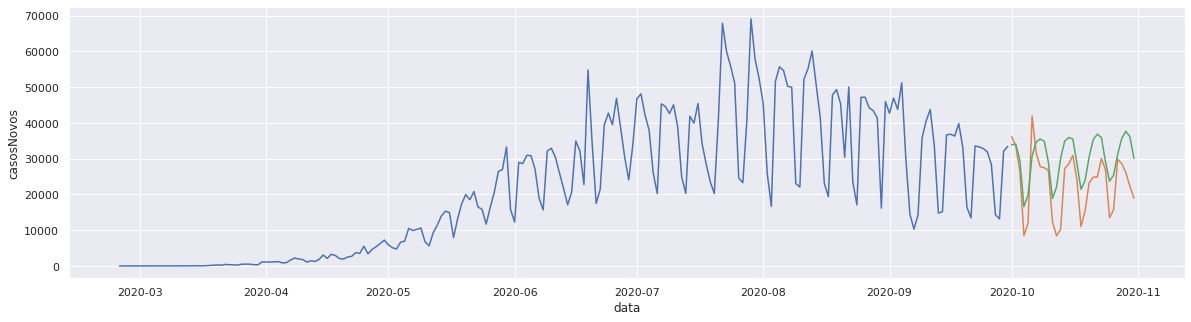

In [100]:
plt.figure(figsize=(20,5))
sns.lineplot(x=casos_treino.index,y="casosNovos",data = casos_treino)
sns.lineplot(x=casos_teste.index,y="casosNovos",data = casos_teste)
sns.lineplot(x=casos_teste.index,y='casos_previsao',data=casos_teste)

#Prevendo óbitos Novos - Brasil

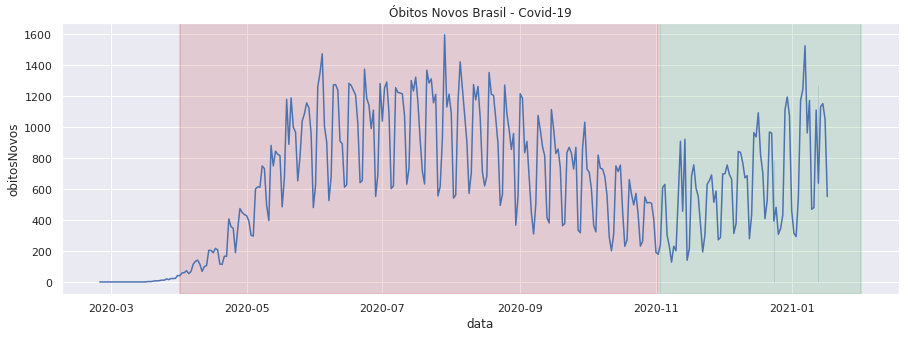

In [23]:
plot_br(br_casos_obitos,"obitosNovos",'Óbitos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-04-01'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)